# Comparative Analysis of Economic Performance on unseen Data

# config and imports

In [16]:
from narwhals import Datetime
from torch.cuda.nvtx import mark
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Pfad zum Projekt-Root hinzufügen, um das Package 'src' zu finden
# Annahme: Dieses Notebook liegt in src/notebooks/
import sys
from pathlib import Path

import joblib
import pandas as pd
from tqdm import tqdm
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# custom imports
PROJECT_ROOT = Path(__file__).resolve().parent.parent.parent if "__file__" in locals() else Path("../../..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.d_eval.evaluation.loader import load_model, load_test_data_v2
from src.d_eval.evaluation.style import apply_shap_style, get_model_style, save_plot
import src.b_feature_eng
sys.modules['src.features'] = sys.modules["src.b_feature_eng"]

apply_shap_style()

In [18]:
# paths
DATA_DIR = "/Users/robin/PycharmProjects/Masterarbeit_Public/data/parquet/features/asinh1-reg"
VAL_SET_PATH = DATA_DIR + "/splits/test_purged.parquet"
SCALER_PATH = DATA_DIR + "/scaler/scaler.joblib"
MODELS_DIR = "/Users/robin/PycharmProjects/Masterarbeit_Public/models"
PRICES_DIR = "/Users/robin/PycharmProjects/Masterarbeit_Public/data/parquet/backtest/prices.parquet"

# target
TARGET_COL = "label_5min"
THINNING_FREQ_MIN = 5

# data
TTD_MINUTES_MIN = 30
TTD_MINUTES_MAX = 300

# models
MODEL_PATHS = {
    "CatBoost": MODELS_DIR + "/" + "CatBoostGPU.joblib",
    "MLP": MODELS_DIR + "/" + "MLP.joblib",
    "RF": MODELS_DIR + "/" + "RandomForest.joblib",
    "EBM": MODELS_DIR + "/" + "ebm.joblib",
    "LASSO": MODELS_DIR + "/" + "Lasso_LargeScale.joblib",
}

BEST_THRESHOLDS = {
    'MLP': 2.0,
    'CatBoost': 3.0,
    'LASSO': 2.0,
    "EBM": 3.0,
    "RF": 3.5,
}

# load data & models

In [19]:
# init scaler
scaler = joblib.load(SCALER_PATH)
ttd_col_name = scaler.ttd_col  # Meistens 'te_min_to_delivery'
print("Scaler geladen.")
print(f"TTD-Spaltenname im Scaler: {ttd_col_name}")

Scaler geladen.
TTD-Spaltenname im Scaler: time_to_delivery_min


In [20]:
# load models
models = {}
for model_name, model_path in tqdm(MODEL_PATHS.items(), desc="Modelle laden"):
    model = load_model(model_path)
    models[model_name] = model

Modelle laden:   0%|          | 0/5 [00:00<?, ?it/s]/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Tr

Fixing missing 'multi_class' attribute for MLPRegressor...


In [21]:
# load data and prepare

X_test_scaled, y_test_scaled = load_test_data_v2(
    VAL_SET_PATH,
    target_col=TARGET_COL,
    keep_id_cols=True,
    sample_minutes=THINNING_FREQ_MIN,
    min_ttd_minutes=TTD_MINUTES_MIN, max_ttd_minutes=TTD_MINUTES_MAX

)

# meta col names
product_keys_col = "delivery_start"
snapshot_times_col = "snapshot_times"
ttd_min_col = "ttd_min_to_delivery"

# extract product keys for later use
df_signals = pd.DataFrame({
    product_keys_col: X_test_scaled['delivery_start'],
    snapshot_times_col: X_test_scaled['snapshot_times']
}, index=X_test_scaled.index)

df_signals[ttd_min_col] = (df_signals[product_keys_col] - df_signals[
    snapshot_times_col]).dt.total_seconds() / 60

print("-" * 30)
print(f"Anzahl Test-Samples (nach Downsampling): {len(y_test_scaled):,}")

# retransform true values
df_temp = pd.DataFrame({
    TARGET_COL: y_test_scaled,
    ttd_col_name: df_signals[ttd_min_col]
}, index=X_test_scaled.index)
df_inv = scaler.inverse_transform(df_temp)
y_test_raw = df_inv[TARGET_COL].values

X_test_scaled[scaler.ttd_col] = (X_test_scaled[product_keys_col] - X_test_scaled[
    snapshot_times_col]).dt.total_seconds() / 60
X_test_raw = scaler.inverse_transform(X_test_scaled)

# drop id cols from features
X_test_scaled = X_test_scaled.drop(columns=['delivery_start', "snapshot_times", scaler.ttd_col])

Memory usage of dataframe is 747.76 MB
Memory usage after optimization is: 724.87 MB
Decreased by 3.1%
Downsampling (Relativ 5min): Von 2,000,203 auf 71,628 Zeilen reduziert.
Clipping TTD window to range: 30 - 300 minutes
Rows to be clipped based on TTD min: 6565 / 71628 (9.17%)
Rows to be clipped based on TTD max: 0 / 71628 (0.00%)
Data shape after clipping TTD window: (65063, 80)
------------------------------
Anzahl Test-Samples (nach Downsampling): 65,063


Inverse transforming features with Asinh1Scaler: 100%|██████████| 61/61 [00:00<00:00, 1413.46it/s]


In [22]:
# generate predictions and inverse transform
preds_scaled = {}
preds_raw = {}

for model_name, model in tqdm(models.items(), desc="Modelle laden und Vorhersagen generieren"):
    # predict
    y_pred_scaled = model.predict(X_test_scaled)
    preds_scaled[model_name] = y_pred_scaled

    # Inverse transform der Vorhersagen
    df_temp = pd.DataFrame({
        TARGET_COL: y_pred_scaled,
        ttd_col_name: df_signals[ttd_min_col]
    }, index=X_test_scaled.index)
    df_inv = scaler.inverse_transform(df_temp)
    preds_raw[model_name] = df_inv[TARGET_COL].values


Inverse transforming features with Asinh1Scaler: 100%|██████████| 61/61 [00:00<00:00, 34172.91it/s]

Inverse transforming features with Asinh1Scaler: 100%|██████████| 61/61 [00:00<00:00, 30870.24it/s]

Modelle laden und Vorhersagen generieren: 100%|██████████| 5/5 [00:00<00:00,  6.17it/s]


# load price data

In [23]:
from src.d_eval.evaluation.economic_performance import build_backtest_foundation

bid_ask_prices = pd.read_parquet(PRICES_DIR)

df_backtest_substrate = build_backtest_foundation(
    df_signals,
    bid_ask_prices,
    preds_raw,
    execution_latency_sec=10,
    price_staleness_limit_sec=0,
)

del bid_ask_prices

ℹ️ Prepared 63,581 samples. Dropped 1,482 due to LOB gaps.


Economic Performance Sweep: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


✅ Grafik gespeichert in: figures/econ/oos_sweep_results_curated_best


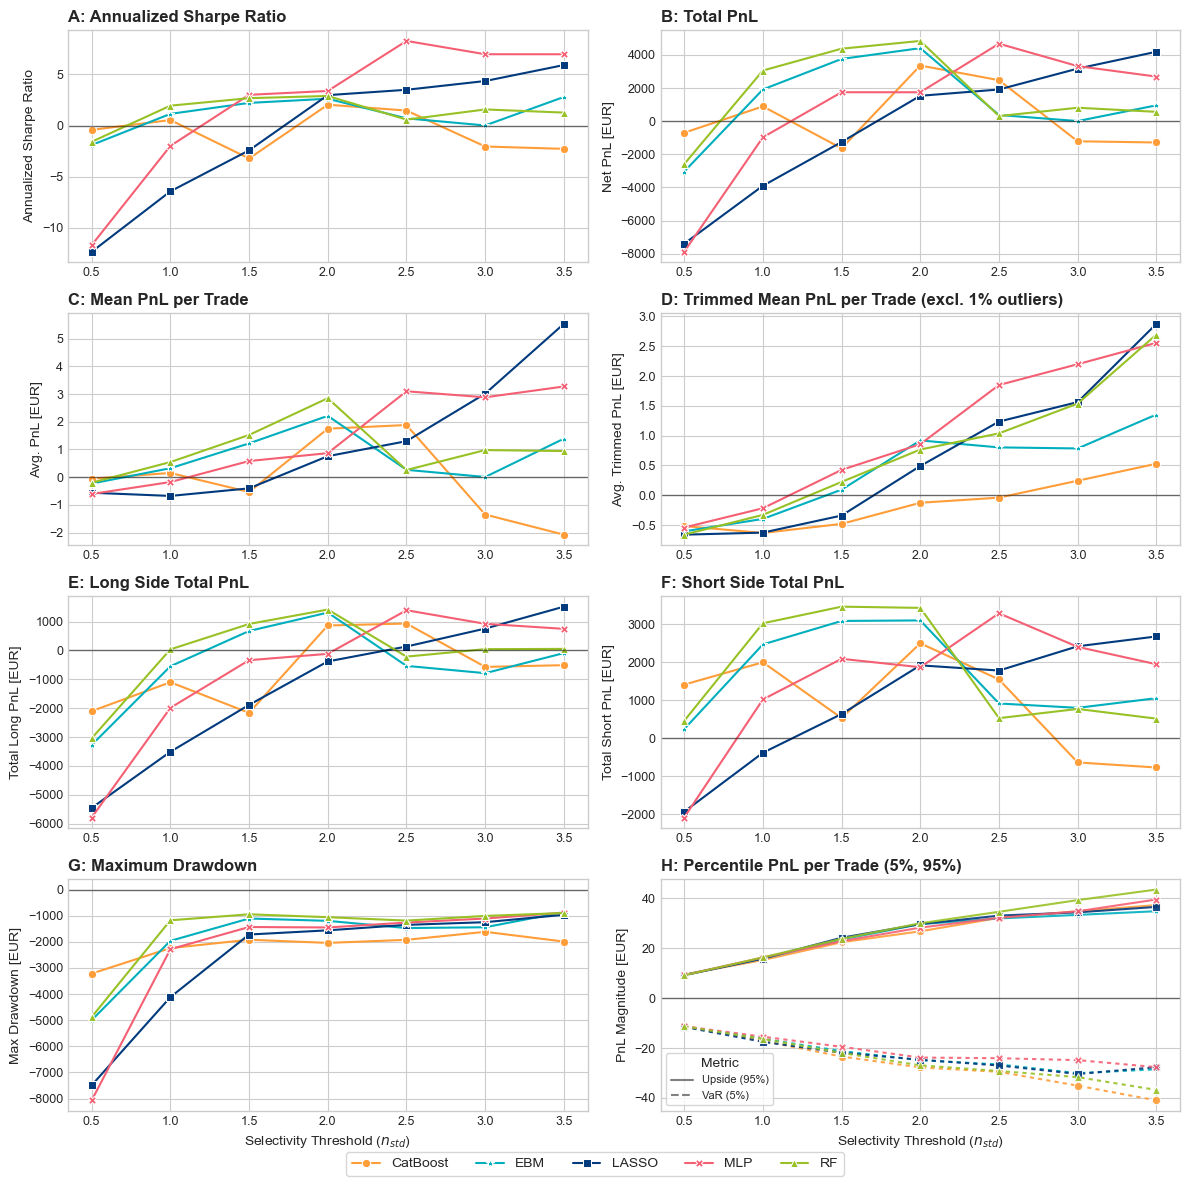

In [24]:
from src.d_eval.evaluation.economic_performance import run_economic_performance_sweep, plot_sweep_results_curated
from src.d_eval.evaluation.tradingStrategyManager import TradingStrategyManager

stats = run_economic_performance_sweep(
    df_backtest_substrate=df_backtest_substrate,
    trading_strategy_logic=TradingStrategyManager.run_threshold_exit_strategy,
    selectivity_range_n_std=np.linspace(0.5, 3.5, 7),
    t_exit_ratio=-1,  # -1 symmetric, negative -> exit on opposite signal
    spread_factor=0.5,  # Beispiel für ein Kwarg
    trade_mode="both",  # Beispiel für ein Kwarg
)
plot_sweep_results_curated(stats, save_name="oos_sweep_results_curated_best")

In [25]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from src.d_eval.evaluation.tradingEvaluator import TradingEvaluator
from src.d_eval.evaluation.tradingStrategyManager import TradingStrategyManager
from src.d_eval.evaluation.economic_performance import calculate_dynamic_thresholds


def evaluate_out_of_sample_with_evaluator(
        df_backtest_substrate: pd.DataFrame,
        model_thresholds: dict = None,
        default_n_std: float = 2.0,
        target_t_exit_ratio: float = -1.0,
        spread_factor: float = 0.5,
        models_to_compare: list = None,
        metrics: list = None
) -> pd.DataFrame:
    """
    Führt den Backtest mit modellspezifischen Thresholds aus und
    nutzt den TradingEvaluator.calculate_all() für die Metriken-Berechnung.
    """
    if model_thresholds is None:
        model_thresholds = {}

    if models_to_compare is None:
        models_to_compare = [c.replace('pred_', '') for c in df_backtest_substrate.columns if c.startswith('pred_')]
        sort_order = ['LASSO', 'EBM', 'RF', 'CatBoost', 'MLP']
        models_to_compare = sorted(models_to_compare, key=lambda x: sort_order.index(x) if x in sort_order else 99)

    # 1. Evaluation Days dynamisch aus dem Datensatz berechnen
    min_date = pd.to_datetime(df_backtest_substrate['delivery_start']).min()
    max_date = pd.to_datetime(df_backtest_substrate['delivery_start']).max()
    evaluation_days = max(1, (max_date - min_date).days)

    results = []
    print(f"Berechne Out-of-Sample Metriken über TradingEvaluator ({evaluation_days} Tage)...")

    for model_name in tqdm(models_to_compare, desc="Evaluating Models"):
        model_col = f"pred_{model_name}"
        current_n_std = model_thresholds.get(model_name, default_n_std)

        # 2. Dynamische Thresholds berechnen
        t_long, t_short, t_l_exit, t_s_exit = calculate_dynamic_thresholds(
            df_backtest_substrate[model_col], current_n_std, current_n_std * target_t_exit_ratio
        )

        # 3. Strategie simulieren
        trades = TradingStrategyManager.run_threshold_exit_strategy(
            df_backtest_substrate, model_col, t_long, t_short, t_l_exit, t_s_exit, spread_factor=spread_factor
        )

        if trades:
            df_trades = pd.DataFrame(trades)

            # Wichtig: Datetime-Formate für den Evaluator sicherstellen
            if 'exit_time' in df_trades.columns:
                df_trades['exit_time'] = pd.to_datetime(df_trades['exit_time'])
            if 'entry_time' in df_trades.columns:
                df_trades['entry_time'] = pd.to_datetime(df_trades['entry_time'])
            if 'delivery_start' in df_trades.columns:
                df_trades['delivery_start'] = pd.to_datetime(df_trades['delivery_start'])

            # 4. TRADING EVALUATOR AUFRUFEN
            metrics_dict = TradingEvaluator.calculate_all(df_trades, evaluation_days=evaluation_days)
        else:
            # Fallback für Modelle ohne Trades (Evaluator gibt hier ein reduziertes Dict zurück)
            metrics_dict = TradingEvaluator.calculate_all(pd.DataFrame(), evaluation_days=evaluation_days)

        # Modell-Infos hinzufügen
        metrics_dict['Model'] = f"{model_name} (n_std={current_n_std})"

        results.append(metrics_dict)

    # 5. DataFrame erstellen
    df_results = pd.DataFrame(results)

    # Fehlende Werte (durch Fallbacks bei 0 Trades) mit 0 auffüllen
    df_results = df_results.fillna(0.0)

    # Spalten elegant ordnen: Model und n_std ganz nach links
    all_cols = metrics if metrics is not None else df_results.columns
    cols = ['Model'] + [c for c in all_cols if c not in ['Model']]
    df_results = df_results[cols]

    # Nach Sharpe Ratio sortieren, falls vorhanden
    if 'Annualized Sharpe Ratio' in df_results.columns:
        df_results = df_results.sort_values(by='Annualized Sharpe Ratio', ascending=False).reset_index(drop=True)

    return df_results


# --- AUFRUF ---
df_metrics = evaluate_out_of_sample_with_evaluator(
    df_backtest_substrate=df_backtest_substrate,
    model_thresholds=BEST_THRESHOLDS,
    # metrics=[
    #     "Annualized Sharpe Ratio",
    #     "Max Drawdown [EUR]",
    #     "Total PnL [EUR]",
    #     "Mean PnL per Trade [EUR]",
    #     "Total Trades",
    #     "VaR (0.05) [EUR]",
    # ]
)

# Transponierte Ansicht (.T), da dein Evaluator sehr viele Spalten generiert!
print("\n=== OUT-OF-SAMPLE PERFORMANCE METRICS ===")
df_metrics

Berechne Out-of-Sample Metriken über TradingEvaluator (57 Tage)...


Evaluating Models: 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]


=== OUT-OF-SAMPLE PERFORMANCE METRICS ===


,Model,Annualized Sharpe Ratio,Max Drawdown [EUR],Total PnL [EUR],Mean PnL per Trade [EUR],Trimmed Pnl (+-0.5%) per Trade [EUR],Trade Frequency [Trades/Day],Total Trades,Mean Holding Time per Trade [minutes],Long PnL [EUR],Short PnL [EUR],PnL Balance (L/S),Total Trades Long,Total Trades Short,VaR (0.05) [EUR],Upside Potential (0.95) [EUR],Economic Efficiency Ratio,Alpha Capture Ratio,Total Frictional Loss [EUR]
0,MLP (n_std=2.0),3.387839,-1451.2375,1744.6450,0.867983,0.856820,35.263158,2010,110.845854,-117.7550,1862.4000,-1.000000,617,1393,-23.845125,28.175375,0.465025,0.950180,2007.0750
1,LASSO (n_std=2.0),2.978548,-1561.2100,1531.4200,0.758129,0.490935,35.438596,2020,104.913284,-380.2150,1911.6350,-1.000000,719,1301,-24.729750,29.591750,0.412258,0.929336,2183.2950
2,RF (n_std=3.5),1.271186,-898.3475,563.4675,0.943832,2.694238,10.473684,597,125.701843,53.6050,509.8625,-0.809732,38,559,-36.796000,43.427000,0.349564,0.839483,1048.4475
3,EBM (n_std=3.0),0.013979,-1443.4425,6.5600,0.006646,0.785219,17.315789,987,122.690138,-787.2425,793.8025,-1.000000,214,773,-30.084500,33.277750,0.005157,0.868008,1265.3750
4,CatBoost (n_std=3.0),-2.044770,-1617.6700,-1211.9225,-1.349580,0.244418,15.754386,898,123.547513,-569.3175,-642.6050,0.060472,178,720,-35.100875,34.744000,0.000000,0.000000,1202.5825


/Users/robin/PycharmProjects/Masterarbeit_Public/src/d_eval/evaluation/economic_performance.py:602: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='delivery_hour', y='pnl', ax=ax5, palette="Blues", showfliers=False)
/Users/robin/PycharmProjects/Masterarbeit_Public/src/d_eval/evaluation/economic_performance.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='ttd_cluster', y='pnl', order=ordered_ttd, ax=ax6, palette="Reds", showfliers=False)


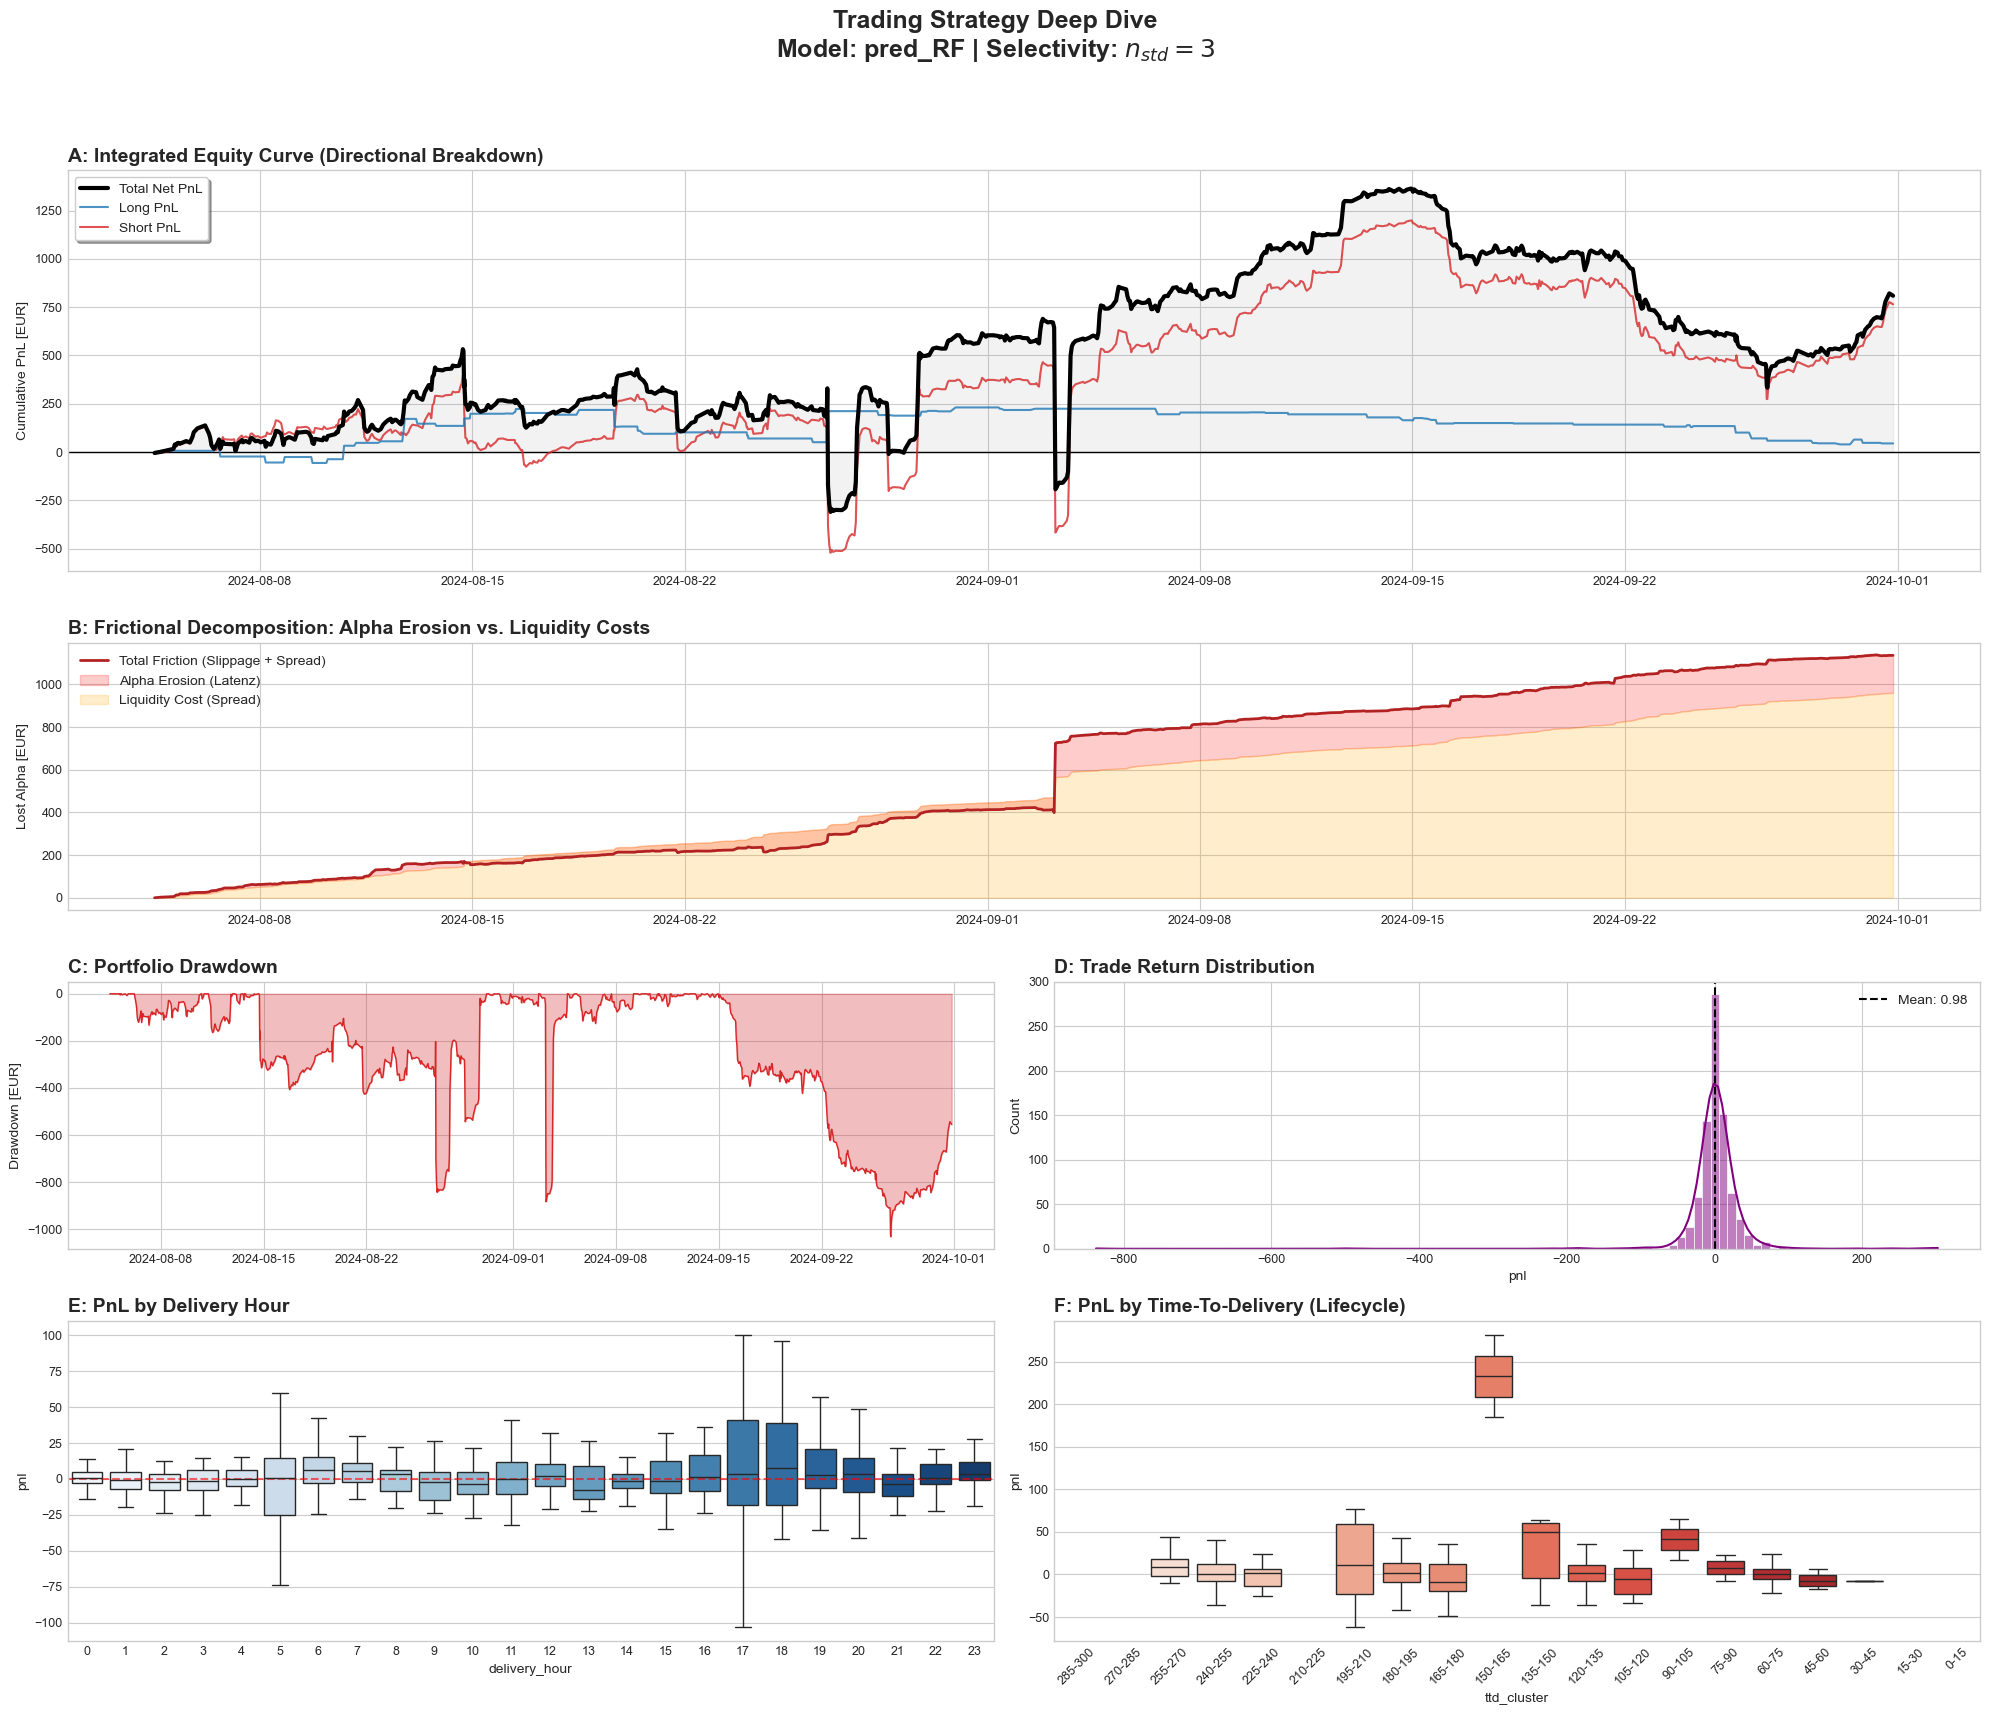

,delivery_start,entry_time,exit_time,side,pnl,slippage_loss,spread_loss,reason
0,2024-08-04 13:00:00,2024-08-04 11:00:10,2024-08-04 12:25:10,SHORT,-5.0975,-1.355,1.2925,Gate Closure
1,2024-08-04 18:00:00,2024-08-04 15:55:00,2024-08-04 17:25:00,LONG,6.2625,1.545,1.3025,Gate Closure
2,2024-08-05 04:00:00,2024-08-04 23:55:00,2024-08-05 03:25:00,SHORT,15.2325,2.290,0.4225,Gate Closure
3,2024-08-05 05:00:00,2024-08-05 03:50:00,2024-08-05 04:25:00,SHORT,22.8050,0.645,2.0950,Gate Closure
4,2024-08-05 06:00:00,2024-08-05 03:50:00,2024-08-05 05:25:00,SHORT,-4.4300,0.015,4.7100,Gate Closure
...,...,...,...,...,...,...,...,...
822,2024-09-30 13:00:00,2024-09-30 09:04:10,2024-09-30 12:29:10,SHORT,23.7050,-1.140,1.3250,Gate Closure
823,2024-09-30 14:00:00,2024-09-30 10:55:00,2024-09-30 13:25:00,SHORT,34.7525,0.245,0.7125,Gate Closure
824,2024-09-30 15:00:00,2024-09-30 12:52:50,2024-09-30 14:27:50,SHORT,29.5875,-0.975,0.1875,Gate Closure
825,2024-09-30 18:00:00,2024-09-30 13:55:00,2024-09-30 17:25:00,SHORT,41.1400,1.020,0.4100,Gate Closure


In [26]:
from src.d_eval.evaluation.economic_performance import calculate_dynamic_thresholds, plot_trading_performance_deep_dive
from src.d_eval.evaluation.tradingStrategyManager import TradingStrategyManager

model_col = "pred_RF"
spread_factor = 0.5
n_std = 3
n_std_exit_factor = -1

t_long, t_short, t_long_exit, t_short_exit = calculate_dynamic_thresholds(df_backtest_substrate[model_col], n_std,
                                                                          n_std * n_std_exit_factor)

log = pd.DataFrame(TradingStrategyManager.run_threshold_exit_strategy(
    df_backtest_substrate=df_backtest_substrate,
    model_column=model_col,
    t_short=t_short,
    t_long=t_long,
    t_exit_long=t_long_exit,
    t_exit_short=t_short_exit,
    spread_factor=spread_factor,
    trade_direction="both",
))

plot_trading_performance_deep_dive(log, model_col, n_std)
log

Generiere Profile mit modellspezifischen Thresholds...


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]
/Users/robin/PycharmProjects/Masterarbeit_Public/src/d_eval/evaluation/economic_performance.py:1063: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax4.set_ylim(0, current_ylim_max)
/Users/robin/PycharmProjects/Masterarbeit_Public/src/d_eval/evaluation/economic_performance.py:1063: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax4.set_ylim(0, current_ylim_max)
/Users/robin/PycharmProjects/Masterarbeit_Public/src/d_eval/evaluation/economic_performance.py:1063: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax4.set_ylim(0, current_ylim_max)
/Users/robin/PycharmProjects/Masterarbeit_Public/src/d_eval/evaluation/economic_performance.py:1063: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax4.set_ylim(0, current_ylim_max)
/Users/robin/PycharmProjects/Masterarbeit_Public/src/d_eval/evaluation

✅ Grafik gespeichert in: figures/econ/oos_alpha_sources_nstd_best


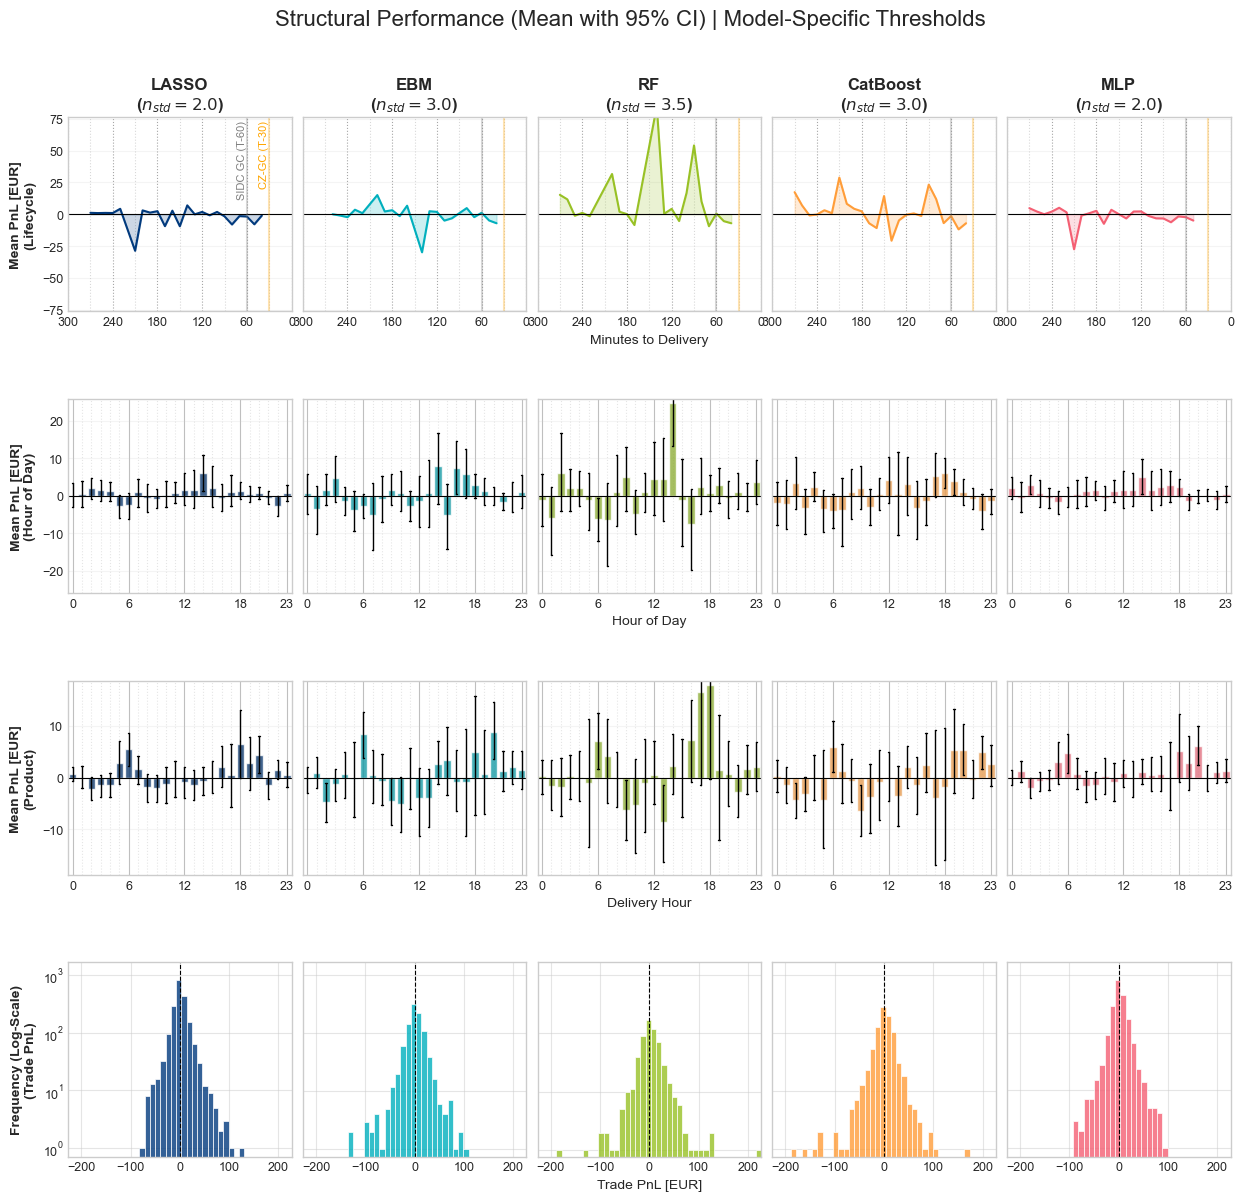

In [27]:
from src.d_eval.evaluation.economic_performance import plot_alpha_sources

# Aufruf
plot_alpha_sources(df_backtest_substrate, model_thresholds=BEST_THRESHOLDS, save_name="oos_alpha_sources_nstd_best",
                   a_y_lim_factor=0.9,
                   b_c_y_lim_factor=1.05)

Berechne Modelle: 100%|██████████| 5/5 [00:00<00:00,  7.48it/s]


✅ Grafik gespeichert in: figures/econ/oos_regime_impact_nstd_best


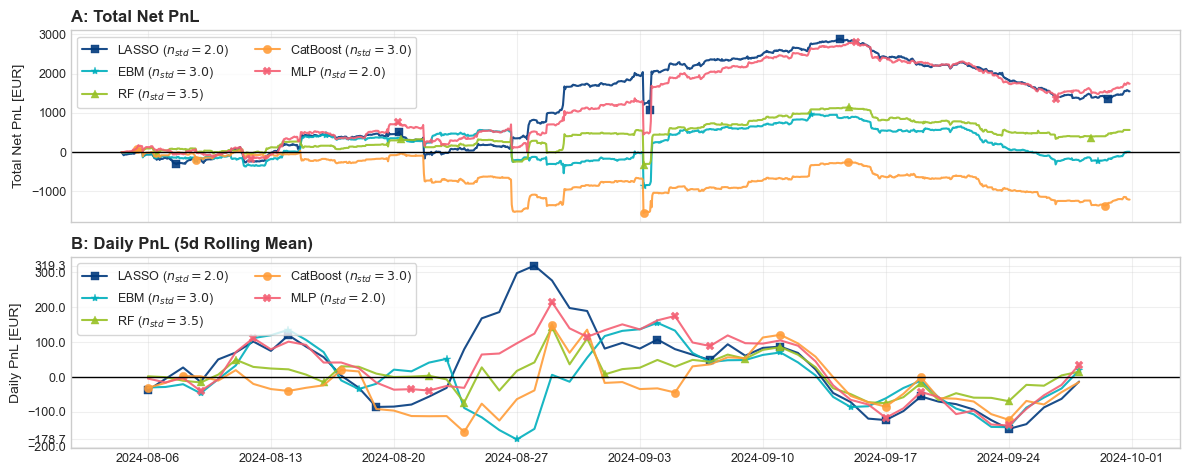

In [28]:
from src.d_eval.evaluation.economic_performance import plot_regime_impact

X_test_raw["total_orderbook_depth"] = (X_test_raw["orderbook_depth_ask"] + X_test_raw["orderbook_depth_bid"])
X_test_raw["total_best_liquidity"] = X_test_raw["liquidity_best_ask"] + X_test_raw["liquidity_best_bid"]

# --- BEISPIEL AUFRUF ---
plot_regime_impact(
    df_backtest_substrate,
    model_thresholds=BEST_THRESHOLDS,
    default_n_std=2,
    X_test=X_test_raw,
    save_name="oos_regime_impact_nstd_best",
    rolling_days=5, target_t_exit_ratio=-1,
)

In [29]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from src.d_eval.evaluation.tradingEvaluator import TradingEvaluator


def evaluate_out_of_sample_with_evaluator(
        df_backtest_substrate: pd.DataFrame,
        model_thresholds: dict = None,
        default_n_std: float = 2.0,
        target_t_exit_ratio: float = -1.0,
        spread_factor: float = 0.5,
        models_to_compare: list = None,
        metrics: list = None
) -> pd.DataFrame:
    """
    Führt den Backtest mit modellspezifischen Thresholds aus und
    nutzt den TradingEvaluator.calculate_all() für die Metriken-Berechnung.
    """
    if model_thresholds is None:
        model_thresholds = {}

    if models_to_compare is None:
        models_to_compare = [c.replace('pred_', '') for c in df_backtest_substrate.columns if c.startswith('pred_')]
        sort_order = ['LASSO', 'EBM', 'RF', 'CatBoost', 'MLP']
        models_to_compare = sorted(models_to_compare, key=lambda x: sort_order.index(x) if x in sort_order else 99)

    # 1. Evaluation Days dynamisch aus dem Datensatz berechnen
    min_date = pd.to_datetime(df_backtest_substrate['delivery_start']).min()
    max_date = pd.to_datetime(df_backtest_substrate['delivery_start']).max()
    evaluation_days = max(1, (max_date - min_date).days)

    results = []
    print(f"Berechne Out-of-Sample Metriken über TradingEvaluator ({evaluation_days} Tage)...")

    for model_name in tqdm(models_to_compare, desc="Evaluating Models"):
        model_col = f"pred_{model_name}"
        current_n_std = model_thresholds.get(model_name, default_n_std)

        # 2. Dynamische Thresholds berechnen
        t_long, t_short, t_l_exit, t_s_exit = calculate_dynamic_thresholds(
            df_backtest_substrate[model_col], current_n_std, current_n_std * target_t_exit_ratio
        )

        # 3. Strategie simulieren
        trades = TradingStrategyManager.run_threshold_exit_strategy(
            df_backtest_substrate, model_col, t_long, t_short, t_l_exit, t_s_exit, spread_factor=spread_factor
        )

        if trades:
            df_trades = pd.DataFrame(trades)

            # Wichtig: Datetime-Formate für den Evaluator sicherstellen
            if 'exit_time' in df_trades.columns:
                df_trades['exit_time'] = pd.to_datetime(df_trades['exit_time'])
            if 'entry_time' in df_trades.columns:
                df_trades['entry_time'] = pd.to_datetime(df_trades['entry_time'])
            if 'delivery_start' in df_trades.columns:
                df_trades['delivery_start'] = pd.to_datetime(df_trades['delivery_start'])

            # 4. TRADING EVALUATOR AUFRUFEN
            metrics_dict = TradingEvaluator.calculate_all(df_trades, evaluation_days=evaluation_days)
        else:
            # Fallback für Modelle ohne Trades (Evaluator gibt hier ein reduziertes Dict zurück)
            metrics_dict = TradingEvaluator.calculate_all(pd.DataFrame(), evaluation_days=evaluation_days)

        # Modell-Infos hinzufügen
        metrics_dict['Model'] = f"{model_name} (n_std={current_n_std})"

        results.append(metrics_dict)

    # 5. DataFrame erstellen
    df_results = pd.DataFrame(results)

    # Fehlende Werte (durch Fallbacks bei 0 Trades) mit 0 auffüllen
    df_results = df_results.fillna(0.0)

    # Spalten elegant ordnen: Model und n_std ganz nach links
    all_cols = metrics if metrics is not None else df_results.columns
    cols = ['Model'] + [c for c in all_cols if c not in ['Model']]
    df_results = df_results[cols]

    # Nach Sharpe Ratio sortieren, falls vorhanden
    if 'Annualized Sharpe Ratio' in df_results.columns:
        df_results = df_results.sort_values(by='Annualized Sharpe Ratio', ascending=False).reset_index(drop=True)

    return df_results


# --- AUFRUF ---
df_metrics = evaluate_out_of_sample_with_evaluator(
    df_backtest_substrate=df_backtest_substrate,
    model_thresholds=BEST_THRESHOLDS,
    # metrics=[
    #     "Annualized Sharpe Ratio",
    #     "Max Drawdown [EUR]",
    #     "Total PnL [EUR]",
    #     "Mean PnL per Trade [EUR]",
    #     "Total Trades",
    #     "VaR (0.05) [EUR]",
    # ]
)

# Transponierte Ansicht (.T), da dein Evaluator sehr viele Spalten generiert!
print("\n=== OUT-OF-SAMPLE PERFORMANCE METRICS ===")
df_metrics

Berechne Out-of-Sample Metriken über TradingEvaluator (57 Tage)...


Evaluating Models: 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


=== OUT-OF-SAMPLE PERFORMANCE METRICS ===


,Model,Annualized Sharpe Ratio,Max Drawdown [EUR],Total PnL [EUR],Mean PnL per Trade [EUR],Trimmed Pnl (+-0.5%) per Trade [EUR],Trade Frequency [Trades/Day],Total Trades,Mean Holding Time per Trade [minutes],Long PnL [EUR],Short PnL [EUR],PnL Balance (L/S),Total Trades Long,Total Trades Short,VaR (0.05) [EUR],Upside Potential (0.95) [EUR],Economic Efficiency Ratio,Alpha Capture Ratio,Total Frictional Loss [EUR]
0,MLP (n_std=2.0),3.387839,-1451.2375,1744.6450,0.867983,0.856820,35.263158,2010,110.845854,-117.7550,1862.4000,-1.000000,617,1393,-23.845125,28.175375,0.465025,0.950180,2007.0750
1,LASSO (n_std=2.0),2.978548,-1561.2100,1531.4200,0.758129,0.490935,35.438596,2020,104.913284,-380.2150,1911.6350,-1.000000,719,1301,-24.729750,29.591750,0.412258,0.929336,2183.2950
2,RF (n_std=3.5),1.271186,-898.3475,563.4675,0.943832,2.694238,10.473684,597,125.701843,53.6050,509.8625,-0.809732,38,559,-36.796000,43.427000,0.349564,0.839483,1048.4475
3,EBM (n_std=3.0),0.013979,-1443.4425,6.5600,0.006646,0.785219,17.315789,987,122.690138,-787.2425,793.8025,-1.000000,214,773,-30.084500,33.277750,0.005157,0.868008,1265.3750
4,CatBoost (n_std=3.0),-2.044770,-1617.6700,-1211.9225,-1.349580,0.244418,15.754386,898,123.547513,-569.3175,-642.6050,0.060472,178,720,-35.100875,34.744000,0.000000,0.000000,1202.5825


In [30]:

# --- AUFRUF ---
df_metrics = evaluate_out_of_sample_with_evaluator(
    df_backtest_substrate=df_backtest_substrate,
    model_thresholds=BEST_THRESHOLDS,
    default_n_std=2,
    metrics=[
        "Annualized Sharpe Ratio",
        "Max Drawdown [EUR]",
        "Total PnL [EUR]",
        "Mean PnL per Trade [EUR]",
        "Total Trades",
        "VaR (0.05) [EUR]",
    ]
)

# Transponierte Ansicht (.T), da dein Evaluator sehr viele Spalten generiert!
print("\n=== OUT-OF-SAMPLE PERFORMANCE METRICS ===")
df_metrics

Berechne Out-of-Sample Metriken über TradingEvaluator (57 Tage)...


Evaluating Models: 100%|██████████| 5/5 [00:00<00:00,  7.49it/s]


=== OUT-OF-SAMPLE PERFORMANCE METRICS ===


,Model,Annualized Sharpe Ratio,Max Drawdown [EUR],Total PnL [EUR],Mean PnL per Trade [EUR],Total Trades,VaR (0.05) [EUR]
0,MLP (n_std=2.0),3.387839,-1451.2375,1744.6450,0.867983,2010,-23.845125
1,LASSO (n_std=2.0),2.978548,-1561.2100,1531.4200,0.758129,2020,-24.729750
2,RF (n_std=3.5),1.271186,-898.3475,563.4675,0.943832,597,-36.796000
3,EBM (n_std=3.0),0.013979,-1443.4425,6.5600,0.006646,987,-30.084500
4,CatBoost (n_std=3.0),-2.044770,-1617.6700,-1211.9225,-1.349580,898,-35.100875
